# SchW-BERT-GAN ファインチューニング
Theorytabデータセットを使用
- 事前学習済みのモデルを使用したSchW-BERT-GAN用のモジュールの定義
    - body選択
    - SchwBertGenerator
    - SchwBertDiscriminator
- SchW-BERT-GANのファインチューニングの実施
    - ファインチューニング用関数を作成
    - 事前学習済みのものと比較
- SchW-BERT-GANによる音楽自動生成
    - コードをデータセットからランダムに選んできて生成

WGAN-gpの実装は[caogang/wgan-gp](https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py)が参考になる

In [1]:
import os, glob, copy, time, math, json, random
import datetime
import hickle as hkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import random_split
from pypianoroll import Track, Multitrack
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, count_params, grid_plot
from bundle import Bundle
from dataloader import TheorytabDataset, TheorytabDataLoader
from model import MusicEmbeddings, MelodyEmbeddings, ChordEmbeddings
from model import ConditionalBertBody, gelu
from model import MultiGPUWrapper
from save_and_load import save_model, load_model
from save_and_load import save_body, load_body
from save_and_load import save_config, load_config

current dir: /root/schwbert


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

input_dir = os.path.join(schwbert_dir, "data", "theorytab")
input_path = os.path.join(input_dir, "original.hkl")

output_base_dir = os.path.join(schwbert_dir, "models")
output_dir = os.path.join(output_base_dir, "theorytab")

for directory in [schwbert_dir, output_base_dir, output_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

### Configのロード

In [3]:
def select_config(directory, postfix=".json"):
    config_paths = glob.glob(os.path.join(directory, f"*{postfix}"))
    config_paths.sort()
    if len(config_paths) > 1:
        print(f"{len(config_paths)} models found in {directory}")
        for i, path in enumerate(config_paths):
            print(f"{i}: {path.split('/')[-1]}")
        config_path = config_paths[int(input("input the number of config:"))]
    else:
        config_path = config_paths[0]
    
    config_name = config_path.split('/')[-1]
    print(f"config is loaded from {config_name}")
    config = load_config(config_name, directory)
    return AttrDict(config)

In [5]:
config = select_config(output_dir)
config.noise_size = 24
config.gp_lambda = 10
print(config)

3 models found in ../datasets/schwbert/models/theorytab
0: albert:config@2019-11-12_07:08.json
1: original:config@2019-11-09_23:32.json
2: original_large:config@2019-11-10_19:00.json


input the number of config: 0


config is loaded from albert:config@2019-11-12_07:08.json
AttrDict({'nickname': 'albert', 'step_num': 768, 'beat_resolution': 12, 'beats_in_bar': 4, 'bar_num': 16, 'melody_pitch_range': [0, 64], 'melody_rest_id': 64, 'melody_mask_id': 65, 'melody_pad_id': 66, 'melody_vocab_size': 67, 'chord_pad_id': 4096, 'chord_vocab_size': 4097, 'fact_size': 12, 'hidden_size': 100, 'intermediate_size': 400, 'attention_layer_num': 16, 'attention_head_num': 10, 'share_all_bert_params': True, 'dropout_prob': 0.1, 'adam_lr': 1e-05, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'pre_mnp_aug': 3, 'pre_mnp_rate': 0.15, 'pre_mnp_mask_rate': 0.8, 'pre_mnp_random_rate': 0.1, 'pre_mnp_keep_rate': 0.1, 'state_names': {'input_embeddings': 'albert:MelodyEmbeddings:E=010H=100I=400A=16AH=10.pth', 'condition_embeddings': 'albert:ChordEmbeddings:E=010H=100I=400A=16AH=10.pth', 'conditional_bert_stack': 'albert:ConditionalBertStack:E=010H=100I=400A=16AH=10.pth', 'masked_note_prediction': 'albert:MaskedNotePrediction:E=010H=10

### データのロード

In [6]:
with Timer():
     bundle_list = hkl.load(input_path)
dataset = TheorytabDataset(bundle_list)
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print("all bundle size:", len(bundle_list))

310.597693
all bundle size: 17396


# SchW-BERT-GAN用のモジュールの定義
- SchwBertGenerator*
    - ConditionalBertBody
        - NoiseEmbeddings*: ノイズベクトルシーケンス→Dense
        - ChordEmbeddings
    - Denseをかけ，メロディを出力
- SchwBertDiscriminator*
    - ConditionalBertBody
        - VecSecEmbeddings*: ベクトルシーケンス→Dense，idsではない
        - ChordEmbeddings
    - Denseを縦横にかけ，本物と偽物を区別するよう2値分類

✳︎ついてるやつが新規作成モジュール

## 各種Embeddingsの実装
偽物のmax通したやつは誤差が伝搬しないのでベクトルシーケンスを入力に取りたい  
本物データにはOneHotになってもらう

In [7]:
class VecSeqEmbeddings(MusicEmbeddings):
    def __init__(self, config, vec_size):
        super(VecSeqEmbeddings, self).__init__(config)
        self.vec_size = vec_size
        self.input_emb = nn.Linear(vec_size, config.hidden_size, bias=False)
    
    def forward(self, input_vec_seq):
        if input_vec_seq.dim() < 3:
            input_vec_seq = self.to_one_hot(input_vec_seq, self.vec_size)
        input_emb = self.input_emb(input_vec_seq)
        embeddings = self.add_fixed_embeddings(input_emb)
        embeddings = self.post_layers(embeddings)
        return embeddings
    
    def to_one_hot(self, input_ids, vec_size):
        device = input_ids.device
        one_hot = torch.eye(vec_size)[input_ids].to(torch.float)
        return one_hot.to(device)

class NoiseEmbeddings(VecSeqEmbeddings):
    def __init__(self, config, pad_id=0):
        super(NoiseEmbeddings, self).__init__(config, config.noise_size)
        self.pad_id = pad_id
    
    def forward(self, input_ids, get_noise=False):
        # input_tesorはデバイス，サイズ，pad箇所の取得用(なのでchordを使う)
        device = input_ids.device
        batch_size, seq_len = input_ids.shape
        
        # ノイズによる埋め込み表現を作成して埋め込み
        noise_vec_seq = torch.randn(batch_size, seq_len, self.vec_size)
        noise_vec_seq[input_ids == self.pad_id] = 0
        embeddings = super().forward(noise_vec_seq.to(device))
        
        if get_noise:
            return embeddings, noise_vec_seq
        else:
            return embeddings

## SchWBertGeneratorの実装

In [8]:
class SchWBertGenerator(nn.Module):
    def __init__(self, config, body):
        super(SchWBertGenerator, self).__init__()
        self.config = config
        self.body = body
        self.pad_id = body.input_embeddings.pad_id
        self.melody_pad_id = config.melody_pad_id
        
        self.dense_1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu_1 = gelu
        self.norm_1 = LayerNorm(config.hidden_size, eps=1e-8)
        self.dense_2 = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu_2 = gelu
        self.norm_2 = LayerNorm(config.hidden_size, eps=1e-8)
        self.dense_3 = nn.Linear(config.hidden_size, config.melody_vocab_size)
        self.gelu_3 = gelu
        self.norm_3 = LayerNorm(config.melody_vocab_size, eps=1e-8)
        self.softmax = nn.Softmax(dim=0)
    
    def forward_head(self, body_output):
        output = self.dense_1(body_output)
        output = self.gelu_1(output)
        output = self.norm_1(output)
        output = self.dense_2(output)
        output = self.gelu_2(output)
        output = self.norm_2(output)
        output = self.dense_3(output)
        output = self.gelu_3(output)
        output = self.norm_3(output)
        output = self.softmax(output)
        return output
        
    def forward(self, condition_tensor, get_all_outputs=False, get_probs=False):
        if get_probs:
            body_output, probs, c_probs = self.body(condition_tensor, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(condition_tensor, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output
        
        output[condition_tensor == self.pad_id] = 0
        output = self.forward_head(output)
        output[condition_tensor == self.pad_id] = self.melody_pad_id
        
        if get_all_outputs:
            output = body_output + output
        
        if get_probs:
            return output, probs, c_probs
        else:
            return output
    
    def to_ids(self, input_tensor):
        probs, preds = torch.max(input_tensor, dim=-1)
        return preds

動作確認

In [9]:
g_body = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), output_dir)
# g_body = ConditionalBertBody(config, MelodyEmbeddings(config), ChordEmbeddings(config))
g_body.input_embeddings = NoiseEmbeddings(config, pad_id=config.chord_pad_id)

G = SchWBertGenerator(config, g_body)

batch = dataloader()
g_out = G(batch.chord)

batch.melody = G.to_ids(g_out)
print(g_out.shape)

torch.Size([2, 768, 67])


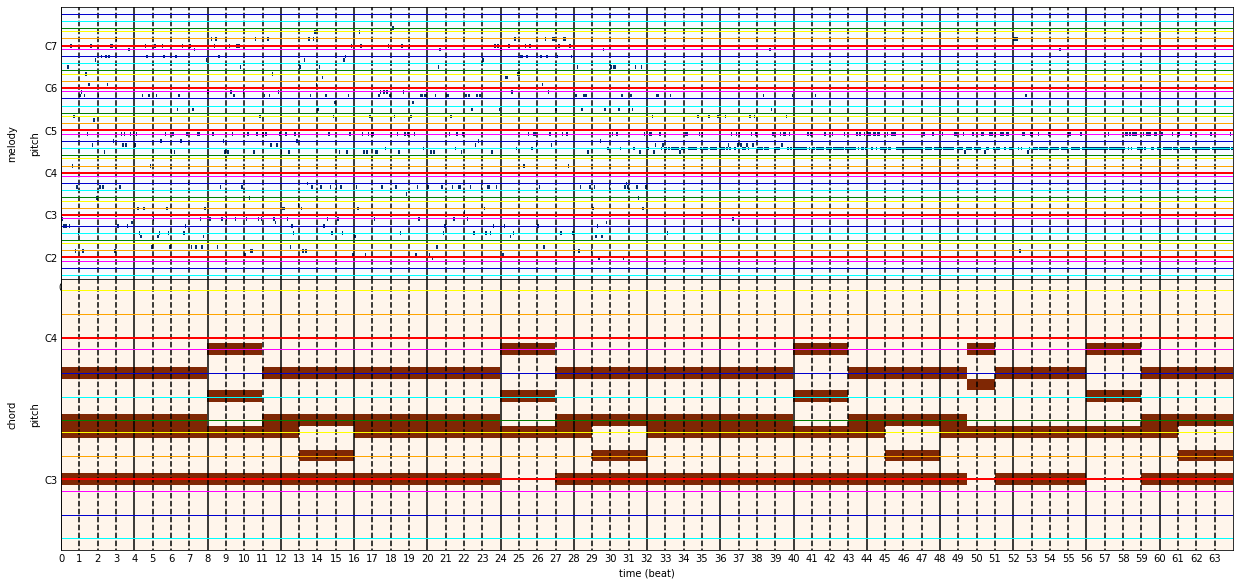

In [10]:
batch_id = 0
bundle = Bundle({
    'melody': batch.melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, 67]
ppr = bundle.get_ppr()
grid_plot(ppr, beat_resolution=bundle.meta.beat_resolution)

## SchWBertDiscriminatorの実装

In [11]:
class SchWBertDiscriminator(nn.Module):
    def __init__(self, config, body):
        super(SchWBertDiscriminator, self).__init__()
        self.config = config
        self.body = body
        self.pad_id = config.chord_pad_id
        
        self.dense_1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu_1 = gelu
        self.norm_1 = LayerNorm(config.hidden_size, eps=1e-8)
        self.dense_2 = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu_2 = gelu
        self.norm_2 = LayerNorm(config.hidden_size, eps=1e-8)
        self.dense_3 = nn.Linear(config.hidden_size, 1)
        self.gelu_3 = gelu
        self.sigmoid = nn.Sigmoid()
    
    def forward_head(self, body_output, pad):
        output = self.dense_1(body_output)
        output = self.gelu_1(output)
        output = self.norm_1(output)
        output = self.dense_2(output)
        output = self.gelu_2(output)
        output = self.norm_2(output)
        output = self.dense_3(output)
        output = self.gelu_3(output)
        
        output[pad] = 0
        pad_denom = pad.sum(dim=-1)
        output = output.squeeze(-1).sum(dim=-1) / pad_denom
        output = self.sigmoid(output)
        return output
            
    def forward(self, input_tensor, condition_tensor, get_all_outputs=False, get_probs=False):
        if get_probs:
            body_output, probs, c_probs = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        else:
            body_output = self.body(input_tensor, condition_tensor, get_all_outputs, get_probs)
        
        if get_all_outputs:
            output = body_output[-1]
        else:
            output = body_output
        
        pad = condition_tensor == self.pad_id
        output[pad] = 0
        output = self.forward_head(output, pad)
        
        if get_all_outputs:
            output = body_output + output
        
        if get_probs:
            return output, probs, c_probs
        else:
            return output

動作確認

In [12]:
d_body = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), output_dir)
# d_body = ConditionalBertBody(config, MelodyEmbeddings(config), ChordEmbeddings(config))
d_body.input_embeddings = VecSeqEmbeddings(config, config.melody_vocab_size)
D = SchWBertDiscriminator(config, d_body)

batch = dataloader()
d_out_real = D(batch.melody, batch.chord)
d_out_fake = D(G(batch.chord), batch.chord)

print("real:", d_out_real)
print("fake:", d_out_fake)

real: tensor([0.4930, 0.4769], grad_fn=<SigmoidBackward>)
fake: tensor([0.4923, 0.4873], grad_fn=<SigmoidBackward>)


# SchW-BERT-GANのファインチューニングの実施
事前学習済みのものとの比較もやる

### 学習用データの作成

In [13]:
batch_size = 2
train_dataset, test_dataset = dataset.split([0.99, 0.01], shuffle=True)
dataloaders_dict = {
    'train': TheorytabDataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'test': TheorytabDataLoader(test_dataset, batch_size=batch_size/2)
}
print(f"train data size: {len(dataloaders_dict['train'].dataset):<5}, batch num: {len(dataloaders_dict['train']):<5}")
print(f" test data size: {len(dataloaders_dict['test'].dataset):<5}, batch num: {len(dataloaders_dict['test']):<5}")

train data size: 17222, batch num: 8611 
 test data size: 174  , batch num: 174  


### モデルの用意

In [14]:
device_ids = [2,3]
# device = torch.device('cuda:2')
device = torch.device('cpu')
multi_gpu = (device_ids != []) & (device.type == 'cuda')

g_body = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), output_dir)
g_body.input_embeddings = NoiseEmbeddings(config, pad_id=config.chord_pad_id)
netG = SchWBertGenerator(config, g_body)

d_body = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), output_dir)
d_body.input_embeddings = VecSeqEmbeddings(config, vec_size=config.melody_vocab_size)
netD = SchWBertDiscriminator(config, d_body)

if multi_gpu:
    print("Use Multi GPUs")
    netG, netD = MultiGPUWrapper(netG), MultiGPUWrapper(netD)

optimizer = optim.Adam([
    {'params': netG.parameters(), 'lr': config.adam_lr},
    {'params': netD.parameters(), 'lr': config.adam_lr},
], betas = (config.adam_beta1, config.adam_beta2))

print("Network settings completed")

Network settings completed


### 学習の実施

まずは通常のGANから始めてみたら？

In [15]:
def calc_gradient_penalty(netD, real_data, fake_data):
    batch_size = real_data.shape[0]
    device = real_data.device
    
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * config.gp_lambda
    return gradient_penalty

In [ ]:
one = torch.FloatTensor([1])
mone = one * -1

for iteration in xrange(ITERS):
    start_time = time.time()
    ############################
    # (1) Update D network
    ###########################
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in xrange(CRITIC_ITERS):
        _data = data.next()
        real_data = torch.Tensor(_data)
        if use_cuda:
            real_data = real_data.cuda(gpu)
        real_data_v = autograd.Variable(real_data)

        netD.zero_grad()

        # train with real
        D_real = netD(real_data_v)
        D_real = D_real.mean()
        # print D_real
        D_real.backward(mone)

        # train with fake
        noise = torch.randn(BATCH_SIZE, 128)
        if use_cuda:
            noise = noise.cuda(gpu)
        noisev = autograd.Variable(noise, volatile=True)  # totally freeze netG
        fake = autograd.Variable(netG(noisev).data)
        inputv = fake
        D_fake = netD(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optimizerD.step()

    ############################
    # (2) Update G network
    ###########################
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    netG.zero_grad()

    noise = torch.randn(BATCH_SIZE, 128)
    if use_cuda:
        noise = noise.cuda(gpu)
    noisev = autograd.Variable(noise)
    fake = netG(noisev)
    G = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    optimizerG.step()

In [ ]:
print("start leaning...")

def save_model(generator, discriminator, epoch, gtt):
    hyper_param_str = f"epoch={epoch:04}_nz={nz}_l1={lambda_1}_l2={lambda_2}_gt={gtt}"
    torch.save(netG.state_dict(), os.path.join(save_dir, f'netG_{hyper_param_str}.pth'))
    torch.save(netD.state_dict(), os.path.join(save_dir, f'netD_{hyper_param_str}.pth'))

if start_epoch is None:
    start_epoch = 0
else:
    realD_list = np.load(os.path.join(save_dir, 'realD_list.npy')).tolist()
    fakeD_list = np.load(os.path.join(save_dir, 'fakeD_list.npy')).tolist()
    lossD_list = np.load(os.path.join(save_dir, 'lossD_list.npy')).tolist()
    lossG_list = np.load(os.path.join(save_dir, 'lossG_list.npy')).tolist()
    gtt_list = np.load(os.path.join(save_dir, 'gtt_list.npy')).tolist()
    

generator_train_times = k
for epoch in range(start_epoch+1, epochs+1):
    sum_lossD, sum_lossG  = 0, 0
    sum_realD, sum_fakeD  = 0, 0
    
    with Timer():
        for i, (real, prev, chord) in enumerate(data_loader):

            # バッチ(譜面，前の譜面，コード)をdeviceに渡す  
            real, prev, chord = [to_device(item) for item in [real, prev, chord]]

            # batchの切れ端はサイズが異なる場合があるので注意
            batch_size = real.size(0)

            ############################
            # Dの学習: log(D(x)) + log(1 - D(G(z))) を最大化
            ###########################

            # Dの勾配の初期化
            netD.zero_grad()

            # realに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_real, d_logits_real, fm_real = netD(real, chord, batch_size)
            d_real_label = torch.rand_like(d_real) * 0.5 + 0.7
            d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

            # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成
            noise = to_device(torch.randn(batch_size, nz))
            fake = netG(noise, prev, chord, batch_size)

            # fakeに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_fake, d_logits_fake, fm_fake = netD(fake.detach(), chord, batch_size)
            d_fake_label = torch.rand_like(d_fake) * 0.3
            d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

            # 誤差逆伝搬により勾配を更新し，それに基づきDのパラメータを更新する
            lossD = d_loss_real + d_loss_fake
            lossD.backward(retain_graph=True)
            optimizerD.step()

            # 学習記録
            # real, fakeデータに対してそれぞれrealだと識別した割合
            realD, fakeD = d_real.mean().item(), d_fake.mean().item()
            sum_realD += realD
            sum_fakeD += fakeD
            sum_lossD += lossD.item() # Dの学習におけるLoss


            ############################
            # Gの学習 : log(D(G(z)))を最大化
            ###########################

            for t in range(generator_train_times):

                # Gの勾配の初期化
                netG.zero_grad()

                # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成 (やっぱりいちいち作ったほうが結果がよさそう)
                noise = to_device(torch.randn(batch_size, nz))
                fake = netG(noise, prev, chord, batch_size)
                
                # fakeに対して1をラベルとした識別結果からクロスエントロピー誤差(目的関数)の値を得てGの誤差とする
                d_fake, d_logits_fake, fm_fake = netD(fake, chord, batch_size)
                deceive_label = torch.ones_like(d_fake)
                g_loss = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label) # (72, 1), (72, 1) => scalar tensor

                # Dの特徴マッチング：realとfakeでnetDの初段のreluの出力が近くなるようにする
                features_from_g = torch.mean(fm_fake, 0) # fakeデータに対するDのfeatureの平均値
                features_from_i = torch.mean(fm_real, 0) # realデータに対するDのfeatureの平均値
                # fakeとrealの出すfeatureの違いが大きいほどペナルティを与える
                fm_g_loss1 = nn.MSELoss(reduction='sum')(features_from_g, features_from_i) / 2
                fm_g_loss1 = torch.mul(fm_g_loss1, lambda_1)

                # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                mean_image_from_g = torch.mean(fake, 0) # fakeデータの平均値
                mean_image_from_i = torch.mean(real, 0) # realデータの平均値
                # fakeデータとrealデータの違いが大きいほどペナルティを与える
                fm_g_loss2 = nn.MSELoss(reduction='sum')(mean_image_from_g, mean_image_from_i) / 2
                fm_g_loss2 = torch.mul(fm_g_loss2, lambda_2)

                # 誤差逆伝搬により勾配を更新し，それに基づきGのパラメータを更新する
                lossG = g_loss + fm_g_loss1 + fm_g_loss2
                lossG.backward(retain_graph=(t < generator_train_times - 1)) # 最後は計算グラフを放棄
                optimizerG.step()

            # 学習記録
            sum_lossG += lossG.item() # Gの学習におけるLoss

        clear_output()
        print(f"epoch {epoch} / {epochs} result")
        
        # エポックごとの識別と誤差の記録
        realD_list.append(sum_realD / data_size)
        fakeD_list.append(sum_fakeD / data_size)
        lossD_list.append(sum_lossD / data_size)
        lossG_list.append(sum_lossG / data_size)
        gtt_list.append(generator_train_times)
        
        # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
        avg_realD = sum_realD / data_size
        avg_fakeD = sum_fakeD / data_size
        generator_train_times = min(48, max(1, int((avg_realD - avg_fakeD) * 100)) * k)
        print(f"==> next generator train times: {generator_train_times}")
        
        print(f'==> avg lossD: {lossD_list[-1]:.4f} avg lossG: {lossG_list[-1]:.4f}, avg realD: {realD_list[-1]:.4f}, avg fakeD: {fakeD_list[-1]:.4f} ')
        print(f'==> last values[ loss D: {lossD:.4f} loss G: {lossG:.4f} = {g_loss:.4f} + {fm_g_loss1:.4f} + {fm_g_loss2:.4f} real D: {realD:.4f} fake D: {fakeD:.4f} ]')
            
    # epochs/save_frequency ごとにモデルとここまでの誤差リストを保存し，生成データを画像で記録
    if epoch % (epochs // save_frequency) == 0:
        save_model(netG, netD, epoch, generator_train_times)
        
        sample_fake = netG(noise_for_sample, prev[:sample_bar_num], chord[:sample_bar_num], sample_bar_num).detach()
        _, _, steps, pitch_range = sample_fake.shape
        sample_fake = sample_fake.reshape(sample_bar_num*steps, pitch_range).T

        fake_image_path = os.path.join(save_dir, f'fake_samples_epoch{epoch:03}.png')
        saved_image_paths.append(fake_image_path)
        vutils.save_image(sample_fake, fake_image_path, normalize=True)

        save_npa('realD_list.npy', realD_list)
        save_npa('fakeD_list.npy', fakeD_list)
        save_npa('lossD_list.npy', lossD_list)
        save_npa('lossG_list.npy', lossG_list)
        save_npa('gtt_list.npy', gtt_list)

print("finished!")

## ファインチューニング用関数を作成